# Best Neighborhood for Dining

## Introduction

Pittsburgh has countless options for dining, and each neighborhood has their own unique selection. It can be difficult to decide which one is most worth frequenting. We wanted to find out which neighborhood would provide the best dining experience.

### Metric
To determine the best neighborhood, we figured out which neighborhood had the best dining experience. This is done by analzying:
- Selection
    - Number of establishments
- Quality
    - Ratings
- Likelyhood of being harmed
    - Health violations
    - Nearby fire incidents 
    - Nearby police incidents

### Datasets
Datasets:
- Pittsburgh Restauraunt Data
- Fire Incidents
- Police Incidents
- Health Violations

### Approach
We chose to analyze each business individually before aggregating the results into their respective neighborhoods to provide more accurate and localized results. This is because the statistics for an entire neighborhood may not necessarily be representative of the businesses within that neighborhood. They are linked back to the main business dataset through through an id for each establishments.

## Restauraunt Data Generation

Much of the restauraunt data set was gathered using the Places API of the Google Maps Platform. There was no feature to get a list of locations within in a city or region. So to find restauraunts and cafes in the Pittsburgh, points spread at a regular interval within Pittsburgh were sampled using the Place Search feature, which returns a list of relevant listings in a specified radius of the point. To get the points, we needed to represent the area contained within Pittsburgh. This was the source image that was used.

![Pittsburgh Neighborhoods](../datasets/business_list/assets/Pittsburgh_Pennsylvania_neighborhoods.svg)

The SVG file was edited to be a black and white map, with black pixels representating areas inside Pittsburgh.

![Pittsburgh Boundary Map](../datasets/business_list/assets/pittsburgh.png)

Points were generated on a grid, spaced 1 km apart. These were then checked to see if they were within Pittsburgh.

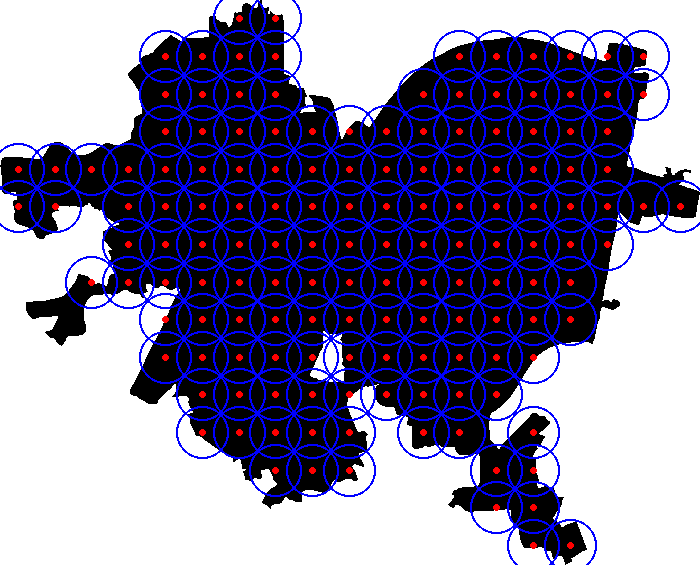

In [1]:
import math
from PIL import Image, ImageDraw

# CONFIG - Search parameters
SPACING = 1

# Geographical information
WEST_EAST_DIST_KM = 19.47 # 85 km per degree longitude
SOUTH_NORTH_DIST_KM = 15.58 # 111 km per degree latitude

# Calculate parameters
RADIUS = SPACING / 2 * math.sqrt(2)
X_INTERVALS = math.floor(WEST_EAST_DIST_KM / SPACING)
X_START = 1 / X_INTERVALS / 2
Y_INTERVALS = math.floor(SOUTH_NORTH_DIST_KM / SPACING)
Y_START = 1 / Y_INTERVALS / 2

# Import map
map = Image.open("../datasets/business_list/assets/pittsburgh.png")
map.load()
drawer = ImageDraw.Draw(map)

RADIUS_PIXELS = math.ceil(RADIUS * map.width / WEST_EAST_DIST_KM)

# Longitude
for x in range(X_INTERVALS):
    x_prop = X_START + x / X_INTERVALS
    pixel_x = math.floor(x_prop * (map.width - 1))

    # Latitude
    for y in range(Y_INTERVALS):
        y_prop = Y_START + y / Y_INTERVALS
        pixel_y = math.floor(y_prop * (map.height - 1))

        # Check intersection
        if (map.getpixel((pixel_x, pixel_y)) == (0, 0, 0, 255)):
            drawer.ellipse((pixel_x - 3, pixel_y - 3, pixel_x + 3, pixel_y + 3), fill="red")
            drawer.ellipse((pixel_x - RADIUS_PIXELS, pixel_y - RADIUS_PIXELS, pixel_x + RADIUS_PIXELS, pixel_y + RADIUS_PIXELS), outline="blue", width=2)

map

If the point was within the boundary (it fell on a black pixel), then it was converted to its corresponding geographical coordinates and used to query the API. The search radius is set to 1.414 km, or sqrt(2) times the spacing to ensure the search covers the entire area. Then, each location returned is queried using Place Details to get more information about each establishment.

In [ ]:
import math, json, time
import googlemaps
from getpass import getpass
from PIL import Image

class API_Session:
    def __init__(self, api_key):
        self.client = googlemaps.Client(key = api_key, timeout=5)
        self.calls = 0

    def call(self, func_name, *args):
        while (True):
            try:
                response = getattr(self, func_name)(*args)
                self.calls += 1
                
                if (response["status"] == "OK"):
                    return response
                else:
                    print("Request error. Status: " + response["status"])
                    input("Press enter to retry.")
            except:
                input("Request failed. Press enter to retry.")

    def first_page(self, latitude, longitude, search_radius, types):
        return self.client.places(location=(latitude, longitude), radius=search_radius, type=types)

    def next_page(self, token):
        return self.client.places(page_token=token)

    def place_details(self, id):
        return self.client.place(place_id=id)

    def get_pages(self, latitude, longitude, search_radius, type, id_list):
        pages = []

        # First page
        page1 = self.call("first_page", latitude, longitude, search_radius, type)
        current_page = page1
        pages.append(page1["results"])

        # Additional pages
        while True:
            token = current_page.get("next_page_token")

            if self.duplicate_count(id_list, current_page["results"]) == 20 or token == None:
                break
            
            time.sleep(2)

            current_page = self.call("next_page", token)
            pages.append(current_page["results"])
        
        return pages

    def duplicate_count(self, id_list, page):
        count = 0
        
        for business in page:
            place_id = business["place_id"]

            if place_id in id_list:
                count += 1
            else:
                id_list.append(place_id)

        return count

# CONFIG - Search parameters
SPACING = 1
TYPES = ["restaurant", "cafe"]

# Geographical information
SOUTH_LIMIT = 40.361370
WEST_LIMIT = -80.095286
NORTH_LIMIT = 40.500925
EAST_LIMIT = -79.865750
WEST_EAST_DIST_DEG = EAST_LIMIT - WEST_LIMIT
WEST_EAST_DIST_KM = 19.47 # 85 km per degree longitude
SOUTH_NORTH_DIST_DEG = NORTH_LIMIT - SOUTH_LIMIT
SOUTH_NORTH_DIST_KM = 15.58 # 111 km per degree latitude

# Calculate parameters
RADIUS = SPACING / 2 * math.sqrt(2)
RADIUS_M = SPACING * 1000
X_INTERVALS = math.floor(WEST_EAST_DIST_KM / SPACING)
X_START = 1 / X_INTERVALS / 2
Y_INTERVALS = math.floor(SOUTH_NORTH_DIST_KM / SPACING)
Y_START = 1 / Y_INTERVALS / 2

# Connect to Google Maps API
api_key = getpass("Enter the API key: ")
api_session = API_Session(api_key)

# PLACE SEARCH
# Import map
map = Image.open("../datasets/business_list/assets/pittsburgh.png")
map.load()

# Query places list from API
output = []
id_list = []

# Longitude
for x in range(X_INTERVALS):
    x_prop = X_START + x / X_INTERVALS
    pixel_x = math.floor(x_prop * (map.width - 1))
    longitude = WEST_LIMIT + x_prop * WEST_EAST_DIST_DEG

    # Latitude
    for y in range(Y_INTERVALS):
        y_prop = Y_START + y / Y_INTERVALS
        pixel_y = math.floor(y_prop * (map.height - 1))
        latitude = NORTH_LIMIT - y_prop * SOUTH_NORTH_DIST_DEG

        # Check intersection
        if (map.getpixel((pixel_x, pixel_y)) == (0, 0, 0, 255)):
            for type in TYPES:
                pages = api_session.get_pages(latitude, longitude, RADIUS_M, type, id_list)

                for page in pages:
                    output.append(page)

# Dump search nearby results
with open("../datasets/business_list/dumps/search_nearby_unprocessed.json", "w", encoding="utf-8-sig") as dump:
    json.dump(output, dump)

# PLACE DETAILS
# Query place details from API
output = []

for place_id in id_list:
    response = api_session.call("place_details", place_id)
    output.append(response["result"])

# Dump search nearby results
with open("../datasets/business_list/dumps/place_details_unprocessed.json", "w", encoding="utf-8-sig") as dump:
    json.dump(output, dump)

# Finish
print("Found " + str(len(id_list)) + " businesses with " + str(api_session.calls) + " API calls")

The output the Place Search and Place Detail queries were dumped into a JSON file to retain all of the information. The Place Details results included the establishment's neighborhood, geographical coordinates, reviews, and opening hours, among other information. This was used to create the business dataset. Only relevant information is extracted and exported to a CSV format, which is more workable. Defunct businesses and businesses not located in Pittsburgh were filtered out the data.

We exported a lot more information to the CSV than we ended up using.

In [3]:
import json, csv

# import json
with open("../datasets/business_list/dumps/place_details_unprocessed.json", "r", encoding="utf-8-sig", newline="") as file:
    place_details = json.load(file)

# import neighborhood list
with open("../datasets/business_list/assets/neighborhood_list.txt", "r") as file:
    neighborhood_list = [name.replace("\n", "") for name in file]

# write to csv
def get_info(business):
    business_status = business.get("business_status")

    # Address components
    address_components = business.get("address_components")
    street_number = None; route = None; neighborhood = None

    for component in address_components:
        level = component["types"][0]

        if level == "street_number":
            street_number = component.get("long_name")
        elif level == "route":
            route = component.get("long_name")
        elif level == "neighborhood":
            neighborhood = component.get("long_name")
        elif level == "postal_code":
            postal_code = component.get("long_name")

    # Filter
    if business_status != "OPERATIONAL" or neighborhood == "" or neighborhood not in neighborhood_list:
        return

    place_id = business.get("place_id")
    name = business.get("name")

    location = business.get("geometry")["location"]
    latitude = location["lat"]
    longitude = location["lng"]

    formatted_address = business.get("formatted_address")

    curbside_pickup = business.get("curbside_pickup")
    price_level = business.get("price_level")
    rating = business.get("rating")
    user_ratings_total = business.get("user_ratings_total")

    # Opening hours
    opening_hours = business.get("opening_hours")
    sun_open = None; sun_close = None; mon_open = None; mon_close = None; tue_open = None; tue_close = None; wed_open = None; wed_close = None; thu_open = None; thu_close = None; fri_open = None; fri_close = None; sat_open = None; sat_close = None

    if (opening_hours != None):
        for day in opening_hours.get("periods"):
            open = day.get("open")
            close = day.get("close") or {}
            day_of_week = open.get("day")

            if day_of_week == 0:
                sun_open = open.get("time")
                sun_close = close.get("time")
            elif day_of_week == 1:
                mon_open = open.get("time")
                mon_close = close.get("time")
            elif day_of_week == 2:
                tue_open = open.get("time")
                tue_close = close.get("time")
            elif day_of_week == 3:
                wed_open = open.get("time")
                wed_close = close.get("time")
            elif day_of_week == 4:
                thu_open = open.get("time")
                thu_close = close.get("time")
            elif day_of_week == 5:
                fri_open = open.get("time")
                fri_close = close.get("time")
            elif day_of_week == 6:
                sat_open = open.get("time")
                sat_close = close.get("time")

    output.append([place_id, name, latitude, longitude, formatted_address, street_number, route, neighborhood, postal_code, curbside_pickup, price_level, rating, user_ratings_total, sun_open, sun_close, mon_open, mon_close, tue_open, tue_close, wed_open, wed_close, thu_open, thu_close, fri_open, fri_close, sat_open, sat_close])

output = []

# csv
with open("../datasets/business_list/business_list.csv", "w", encoding="utf-8-sig", newline='') as csv_out:
    csv_writer = csv.writer(csv_out)
    csv_writer.writerow(["place_id", "name", "latitude", "longitude", "formatted_address", "street_number", "route", "neighborhood", "postal_code", "curbside_pickup", "price_level", "rating", "user_ratings_total", "sun_open", "sun_close", "mon_open", "mon_close", "tue_open", "tue_close", "wed_open", "wed_close", "thu_open", "thu_close", "fri_open", "fri_close", "sat_open", "sat_close"])

    for business in place_details:
        get_info(business)

    csv_writer.writerows(output)

In [133]:
import pandas

business_list = pandas.read_csv("../datasets/business_list/business_list.csv")
business_list.head()

,place_id,name,latitude,longitude,formatted_address,street_number,route,neighborhood,postal_code,curbside_pickup,...,tue_open,tue_close,wed_open,wed_close,thu_open,thu_close,fri_open,fri_close,sat_open,sat_close
0,ChIJhYJfjL31NIgR3phOvhgBNEs,DBO's,40.5,-80.1,"635 Hillsboro St, Pittsburgh, PA 15204, USA",635,Hillsboro Street,Sheraden,15204,NaN,...,1200.0,1800.0,1200.0,1800.0,1200.0,1800.0,1200.0,1800.0,1000.0,1500.0
1,ChIJb1vGv1_2NIgRTz6RVpyC9Do,Angkor Restaurant,40.4,-80.1,"2350 Noblestown Rd # 18, Pittsburgh, PA 15205,...",2350,Noblestown Road,Oakwood,15205,NaN,...,1130.0,2100.0,1130.0,2100.0,1130.0,2100.0,1130.0,2100.0,1130.0,2100.0
2,ChIJb1vGv1_2NIgRHMolqSfzEd4,Blinky's Noble Grill & Bar,40.4,-80.1,"2350 Noblestown Rd # 11, Pittsburgh, PA 15205,...",2350,Noblestown Road,Oakwood,15205,False,...,1100.0,200.0,1100.0,200.0,1100.0,200.0,1100.0,200.0,1100.0,200.0
3,ChIJX9Zv-Zz2NIgRuL5tXjwo8mU,Lorenz Cafe,40.4,-80.0,"718 Lorenz Ave, Pittsburgh, PA 15220, USA",718,Lorenz Avenue,Elliott,15220,False,...,1200.0,2000.0,1200.0,2200.0,1200.0,2200.0,1200.0,2300.0,1200.0,2300.0
4,ChIJPUHlkVH3NIgRMwVmDx22dPM,NakaEndZone BBQ,40.4,-80.1,"1310 Crafton Blvd, Pittsburgh, PA 15205, USA",1310,Crafton Boulevard,Crafton Heights,15205,True,...,NaN,NaN,1200.0,1900.0,1200.0,1900.0,1200.0,1900.0,1200.0,1900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929,ChIJX8zp4sLtNIgR-Y_LhQ6wDe0,Peppi's,40.4,-79.9,"7619 Penn Ave, Pittsburgh, PA 15221, USA",7619,Penn Avenue,Point Breeze North,15221,NaN,...,1000.0,2000.0,1000.0,2000.0,1000.0,2000.0,1000.0,2000.0,1000.0,2000.0
930,ChIJN3RDUXTuNIgR6nGsrFqr8E8,D's Six Pax and Dogz,40.4,-79.9,"1118 S Braddock Ave, Swissvale, PA 15218, USA",1118,South Braddock Avenue,Regent Square,15218,NaN,...,1100.0,2200.0,1100.0,2200.0,1100.0,2200.0,1100.0,2200.0,1100.0,2200.0
931,ChIJ0VPq8RvtNIgRj5Ga8BZOeHA,Chipotle Mexican Grill,40.5,-79.9,"1027 Freeport Rd, Pittsburgh, PA 15238, USA",1027,Freeport Road,Lincoln-Lemington-Belmar,15238,NaN,...,1045.0,2200.0,1045.0,2200.0,1045.0,2200.0,1045.0,2200.0,1045.0,2200.0
932,ChIJP-ftn8rsNIgRKFmLqVQEOs4,Uncle Sam’s Sandwich Bar,40.5,-79.9,"936 Freeport Rd, Pittsburgh, PA 15238, USA",936,Freeport Road,Lincoln-Lemington-Belmar,15238,NaN,...,1100.0,2030.0,1100.0,2030.0,1100.0,2030.0,1100.0,2030.0,1100.0,2030.0


## Choropleth Maps

This is the code for generating the choropleth maps using Geopandas. Because Geopandas does not import additional properties on the geometry, like the neighborhood, this has to be manually read in from the geojson file and appended to the GeoDataFrame. A few string replacements were necesssary to match up the neighborhood names from Google Maps and the geojson file.

In [60]:
import json
import pandas, geopandas
import matplotlib.pyplot as pyplot
import seaborn

# Use seaborn theme
seaborn.set_theme()

%matplotlib inline

geojson_alias = {
    "Downtown": "Central Business District",
    "Uptown": "Bluff",
    "Allegheny-West": "Allegheny West",
    "Lawrenceville": "Upper Lawrenceville"
}

def generate_map(list, value_col):
    # Load data
    map = geopandas.read_file("../util/Neighborhoods_.geojson")

    # Add neighborhood and count column to GeoDataFrame
    neighborhoods = []

    # Get all neighborhoods names from geojson file
    with open("../util/Neighborhoods_.geojson", "r") as geojson_data:
        data = json.load(geojson_data)
        features = data["features"]

        for feature in features:
            region_name = feature["properties"]["hood"]
            neighborhoods.append(region_name)

    # Correct name variations
    incidents_corrected = list.replace(geojson_alias).groupby("neighborhood").mean(numeric_only=True)

    # Combine dataframes
    incidents_append = pandas.DataFrame(neighborhoods, columns=["neighborhood"])
    incidents_append = incidents_append.merge(incidents_corrected, on="neighborhood", how="outer")
    map["neighborhood"] = incidents_append["neighborhood"]
    map[value_col] = incidents_append[value_col]

    return map

## Number of Restauraunts

Text(0, 0.5, 'Neighborhood')

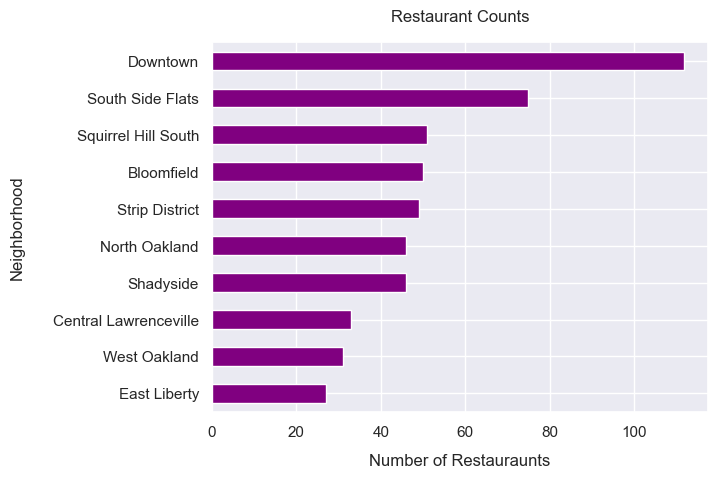

In [102]:
count = business_list.groupby("neighborhood").size()
business_count = pandas.DataFrame(count.values, index=count.keys(), columns=["count"])

business_count.sort_values("count").tail(10).plot.barh(legend=False, color="purple")
pyplot.title("Restaurant Counts", pad=15)
pyplot.xlabel("Number of Restauraunts", labelpad=10)
pyplot.ylabel("Neighborhood", labelpad=20)

(-80.10681505991924, -79.85429464126216, 40.354642646539126, 40.50793371245118)

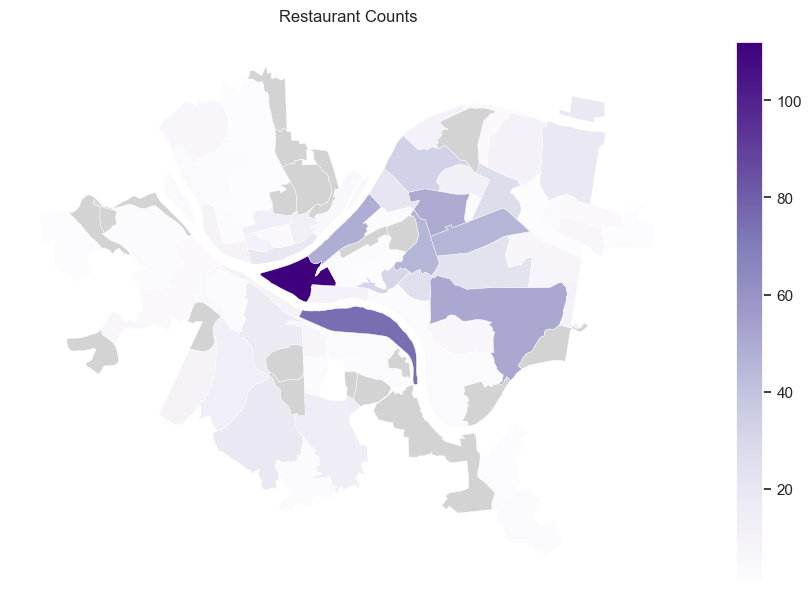

In [100]:
temp = business_list.replace(geojson_alias).groupby("neighborhood").size()
temp_count = pandas.DataFrame(temp.values, index=temp.keys(), columns=["count"])

map = generate_map(temp_count, "count")
fig, ax = pyplot.subplots(1, 1, figsize=(13, 7))
map.plot(ax=ax, column="count", legend=True, cmap="Purples", linewidth=0.3, missing_kwds={"color": "lightgrey"})
pyplot.title("Restaurant Counts", pad=15)
pyplot.axis("off")

# Fire and Police Incident Data

A higher number of nearby incidents indicates that an area is more dangerous, and therefore detrimental to the dining experience. For the safety and therefore best dining experience, the neighborhood needs to have a low number. 

For each business, the number of nearby incidents is determined. The same code below is used for both fire and police incidents, with different parameters passed in. This code skips entries without a valid latitude and longitude value.

In [10]:
import math, csv

# Geographical information
KM_PER_LONGITUDE = 84.82    
KM_PER_LATITUDE = 111.64

# Calculate distance
def km_distance(lat1, lng1, lat2, lng2):
    x_dist = (lng2 - lng1) * KM_PER_LONGITUDE
    y_dist = (lat2 - lat1) * KM_PER_LATITUDE

    return math.sqrt(x_dist ** 2 + y_dist ** 2)

# Calculate incidents within radius of business
def incident_count(incidents, lat, lng, radius, lat_attr, lng_attr):
    count = 0

    for incident in incidents:
        lat2 = incident.get(lat_attr)
        lng2 = incident.get(lng_attr)

        if lng2 != "":
            if km_distance(lat, lng, float(lat2), float(lng2)) <= radius:
                count += 1
    
    return count

def get_nearby_incidents(business_list_path, incident_list_path, radius, lat_attr, lng_attr):
    output = []
    
    # Open data files
    with open(business_list_path, "r", encoding="utf-8-sig") as business_data:
        with open(incident_list_path, "r") as incident_data:
            business_list = csv.DictReader(business_data)
            incidents = [incident for incident in csv.DictReader(incident_data)]

            # For each business
            for business in business_list:
                place_id = business["place_id"]
                neighborhood = business["neighborhood"]
                lng = float(business["longitude"])
                lat = float(business["latitude"])
                count = incident_count(incidents, lat, lng, radius, lat_attr, lng_attr)
                    
                output.append([place_id, neighborhood, count])
    
    return output

## Fire Risk Submetric - Fire Incidents

Hot food is good, but hot buildings are not. A lower number of nearby fire incidents means there is lower the risk of the building catching on fire and posing a risk to customers.

In [11]:
import pandas

pandas.read_csv("../datasets/fire_incidents/assets/fire_incidents.csv").head()

,call_no,incident_type,type_description,address,alarm_time,alarms,primary_unit,census_tract,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,F160029985,111.0,Building fire,"800 BLOCK CENTER ST, WILKINSBURG PA 15221",2016-04-21T05:01:04,1,231EN16,NaN,NaN,NaN,NaN,4.200356e+10,NaN,NaN,NaN,3-16,40.441275,-79.882485
1,F180022058,111.0,Building fire,"1100 BLOCK JANE ST, WILKINSBURG PA 15221",2018-03-13T08:34:43,1,231EN16,NaN,NaN,NaN,NaN,4.200356e+10,NaN,NaN,NaN,3-21,40.436342,-79.881003
2,F180022102,131.0,Passenger vehicle fire,"SB STATE HWY 28 SB AT 31S, PITTSBURGH PA 15212",2018-03-13T11:54:23,0,231EN32,2406.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-1A,NaN,NaN
3,F170043431,131.0,Passenger vehicle fire,"1700 BLOCK BELLEAU DR, PITTSBURGH PA 15212",2017-05-31T08:39:47,0,231EN38,2509.0,Fineview,6.0,25.0,4.200325e+10,1.0,25.0,1.0,1-10,40.460303,-80.006980
4,F180021111,111.0,Building fire,"2400 BLOCK VILLAGE RD, PITTSBURGH PA 15205",2018-03-09T10:26:42,1,231EN31,2808.0,Fairywood,2.0,28.0,4.200356e+10,5.0,28.0,6.0,1-16,40.449009,-80.076607


A radius of 300 meters is used when determining the number of nearby incidents.

In [12]:
import pandas

RADIUS = 0.3

output = get_nearby_incidents("../datasets/business_list/business_list.csv", "../datasets/fire_incidents/assets/fire_incidents.csv", RADIUS, "latitude", "longitude")
fire_incidents = pandas.DataFrame(output, columns=["place_id", "neighborhood", "fire_incidents"])
fire_incidents.head()

,place_id,neighborhood,fire_incidents
0,ChIJhYJfjL31NIgR3phOvhgBNEs,Sheraden,32
1,ChIJb1vGv1_2NIgRTz6RVpyC9Do,Oakwood,5
2,ChIJb1vGv1_2NIgRHMolqSfzEd4,Oakwood,6
3,ChIJX9Zv-Zz2NIgRuL5tXjwo8mU,Elliott,31
4,ChIJPUHlkVH3NIgRMwVmDx22dPM,Crafton Heights,8


Below are the nearby fire incidents for each restauraunt, grouped by neighborhood and averaged.

Text(0, 0.5, 'Neighborhood')

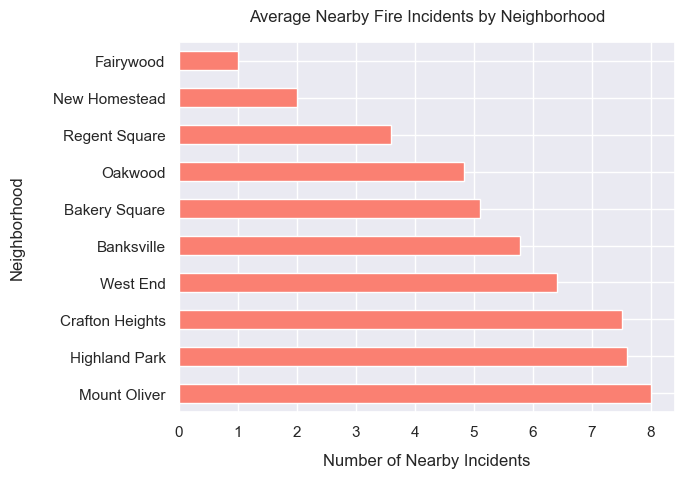

In [135]:
fire_incidents_grouped = fire_incidents.groupby("neighborhood").mean(numeric_only=True).sort_values("fire_incidents", ascending=False)
fire_incidents_grouped.tail(10).plot.barh(legend=False, color="salmon")
pyplot.title("Average Nearby Fire Incidents by Neighborhood", pad=15)
pyplot.xlabel("Number of Nearby Incidents", labelpad=10)
pyplot.ylabel("Neighborhood", labelpad=20)

Here is the same data visualized in a choropleth graph. The grey regions are neighborhoods with no dining places.

(-80.10681505991924, -79.85429464126216, 40.354642646539126, 40.50793371245118)

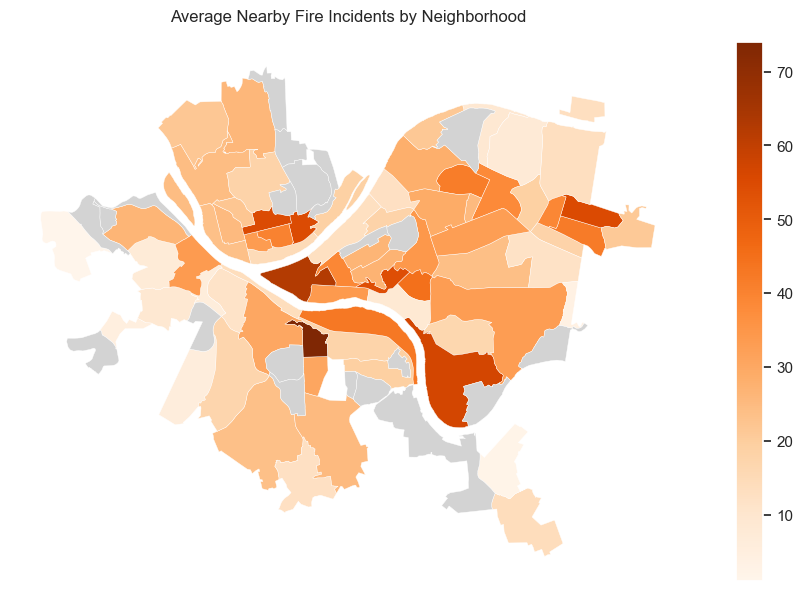

In [14]:
map = generate_map(fire_incidents, "fire_incidents")
fig, ax = pyplot.subplots(1, 1, figsize=(13, 7))
map.plot(ax=ax, column="fire_incidents", legend=True, cmap="Oranges", linewidth=0.3, missing_kwds={"color": "lightgrey"})
pyplot.title("Average Nearby Fire Incidents by Neighborhood", pad=15)
pyplot.axis("off")

## Risk of Harm by Others Submetric - Police Incidents

Nearby police incidents are an indicator of the risk of direct and indirect harm to a customer. Because of this broad interpretation, all types of incidents are included in the analysis. A hit and run of a parked vehicle may not physically hurt a person, but it would sure hurt their dining experience if they were to learn that their car was damaged.

In [15]:
import pandas

pandas.read_csv("../datasets/police_incidents/assets/police_incidents.csv").head()

,PK,CCR,HIERARCHY,INCIDENTTIME,INCIDENTLOCATION,CLEAREDFLAG,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTHIERARCHYDESC,OFFENSES,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
0,-3218234799,22156251,0,2022-09-26T10:48:00,"200 Block Reifert St Pittsburgh, PA 15210",N,Knoxville,3,99,9999 9999 - (Misc. Incident):,3001.0,3.0,5.0,-79.992114,40.408138
1,291943355,22156290,0,2022-09-26T11:53:00,"5000 Block 2nd Ave Pittsburgh, PA 15207",Y,Hazelwood,4,99,9999 9999 - (Misc. Incident):,1515.0,5.0,3.0,-79.943686,40.408550
2,293365062,22165846,10,2022-10-13T07:35:00,"2000 Block 5th Ave Pittsburgh, PA 15219",N,Bluff,2,HARRASSMENT,2709 Harassment (Non-Specific),103.0,6.0,3.0,-79.977533,40.438011
3,293903564,22169167,6,2022-10-18T02:00:00,"500 Block Lockhart St Pittsburgh, PA 15212",N,East Allegheny,1,THEFT,"3924 Theft of Property Lost, Mislaid or Delive...",2304.0,1.0,1.0,-80.000065,40.452558
4,292498416,22159837,0,2022-10-02T13:00:00,"1600 Block Saw Mill Run Blvd Pittsburgh, PA 15210",N,Brookline,6,99,9999 9999 - (Misc. Incident):,3206.0,4.0,5.0,-80.000631,40.399967


The same process used to analyze the fire incidents is applied to police incidents. A radius of 500 meters is used. Again, a lower number is better.

In [16]:
import pandas

RADIUS = 0.5

output = get_nearby_incidents("../datasets/business_list/business_list.csv", "../datasets/police_incidents/assets/police_incidents.csv", RADIUS, "Y", "X")
police_incidents = pandas.DataFrame(output, columns=["place_id", "neighborhood", "police_incidents"])
police_incidents.head()

,place_id,neighborhood,police_incidents
0,ChIJhYJfjL31NIgR3phOvhgBNEs,Sheraden,24
1,ChIJb1vGv1_2NIgRTz6RVpyC9Do,Oakwood,2
2,ChIJb1vGv1_2NIgRHMolqSfzEd4,Oakwood,3
3,ChIJX9Zv-Zz2NIgRuL5tXjwo8mU,Elliott,17
4,ChIJPUHlkVH3NIgRMwVmDx22dPM,Crafton Heights,8


Below are the average nearby police incidents for the restauraunts in each neighborhood, visualized as both a bar chart and a choropleth map.

Text(0, 0.5, 'Neighborhood')

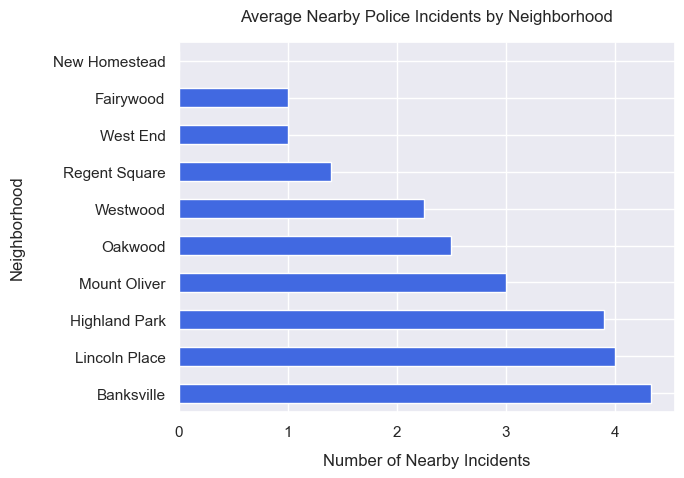

In [17]:
police_incidents_grouped = police_incidents.groupby("neighborhood").mean(numeric_only=True).sort_values("police_incidents", ascending=False)
police_incidents_grouped.tail(10).plot.barh(legend=False, color="royalblue")
pyplot.title("Average Nearby Police Incidents by Neighborhood", pad=15)
pyplot.xlabel("Number of Nearby Incidents", labelpad=10)
pyplot.ylabel("Neighborhood", labelpad=20)

(-80.10681505991924, -79.85429464126216, 40.354642646539126, 40.50793371245118)

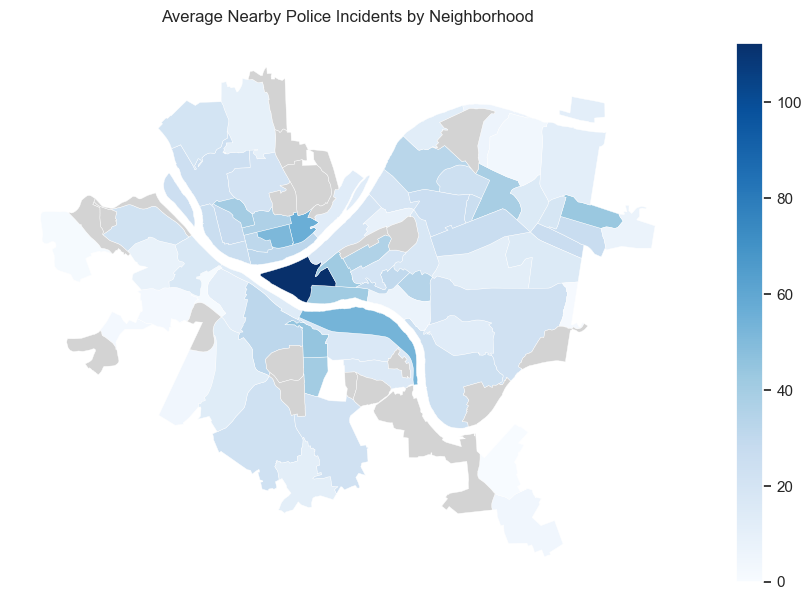

In [18]:
map = generate_map(police_incidents, "police_incidents")
fig, ax = pyplot.subplots(figsize=(13, 7))
map.plot(ax=ax, column="police_incidents", legend=True, cmap="Blues", linewidth=0.3, missing_kwds={"color": "lightgrey"})
pyplot.title("Average Nearby Police Incidents by Neighborhood", pad=15)
pyplot.axis("off")

# Rating
A given restaurant's quality is likely corrleated with it's rating.

Text(0, 0.5, 'Neighborhood')

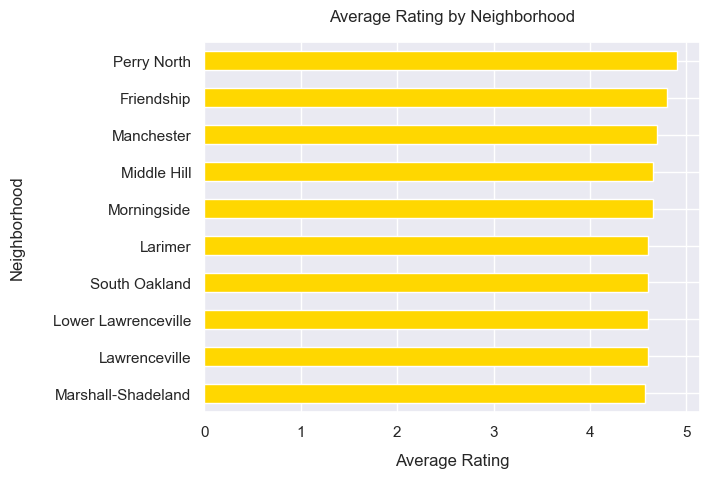

In [69]:
import matplotlib.pyplot as pyplot

neighboorhood_ratings = business_list.groupby('neighborhood')['rating'].mean().sort_values()
neighboorhood_ratings = neighboorhood_ratings[neighboorhood_ratings.notnull()]

ax = neighboorhood_ratings.tail(10).plot.barh(legend=False, color="gold")
pyplot.title("Average Rating by Neighborhood", pad=15)
pyplot.xlabel("Average Rating", labelpad=10)
pyplot.ylabel("Neighborhood", labelpad=20)

(-80.10681505991924, -79.85429464126216, 40.354642646539126, 40.50793371245118)

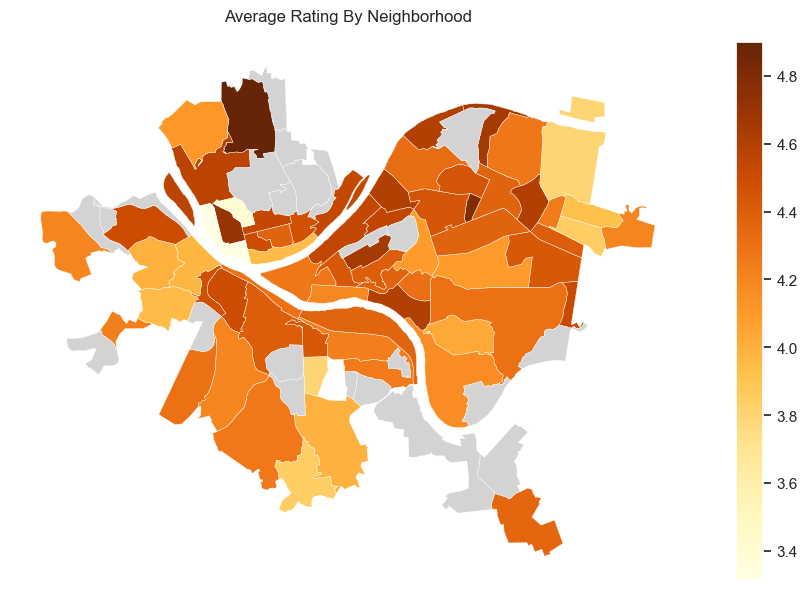

In [70]:
map = generate_map(business_list, "rating")
fig, ax = pyplot.subplots(figsize=(13, 7))
map.plot(ax=ax, column="rating", legend=True, cmap="YlOrBr", linewidth=0.3, missing_kwds={"color": "lightgrey"})
pyplot.title("Average Rating By Neighborhood", pad=15)
pyplot.axis("off")

# Health Violations
Place with more health violations are likely less desriable places to eat

In [71]:
import zipfile
import pandas
with zipfile.ZipFile("../datasets/violations/alco-restuarant-violations.zip","r") as zip_ref:
    zip_ref.extractall("../datasets/violations/") # we extract the file
alco_restuarant_violations = pandas.read_csv("../datasets/violations/alco-restuarant-violations.csv")
geocoded_factilites = pandas.read_csv("../datasets/violations/geo_coded.csv")

The names of restaurants in data from Google Maps don't exactly match the names in the health violations dataset.
In order to match them up, we first check if they share the same zipcode and street number.
Then we check if the restaurants name is approximately similar to each other. One way of doing this is measuring the 
[Levenshtein Distance](https://en.wikipedia.org/wiki/Levenshtein_distance) between the names.

I installed a module called `fuzzywuzzy` that implement Levenshtein Distance. 

In [83]:

import re
from fuzzywuzzy import fuzz 
# pip install fuzzywuzzy

def normalize_names(name):
  name = name.replace('é','e')
  name = re.sub('[^A-Za-z0-9]+', '', name.lower())
  suffxies = ['bar','restaurant','restaurante','cafe','bbq','diner']
  for s in suffxies:
    if name.endswith(s):
      name = name[:-len(s)]
  prefix = ['the']
  for p in prefix:
    if name.startswith(p):
      name = name[len(p):]
  return name


def best_pick(haystack,needle):
  unnormalized_name = needle
  ans = [(fuzz.ratio(normalize_names(needle),normalize_names(z)),i) for i,z in enumerate(haystack)]
  ans.sort(key=lambda x: x[0])
  if ans[-1][0] < 60:
    return None,None
  return ans[-1]


def address_to_id(R):
  fac_name = R['name']
  street_number = R['street_number']
  postal_code = R['postal_code']
  # print(street_number,postal_code,fac_name)
  query = "num == @street_number and zip==@postal_code"
  row = geocoded_factilites.query(query)

  if row.shape[0] == 1:
    return row.iloc[0]['id']

  if row.shape[0] == 0:
    return None
  
  if row.shape[0] > 1:
    names = list(row['facility_name'])
    _,bp = best_pick(names,fac_name)
    if bp == None:
      return None
    return row.iloc[bp]['id']
    
  return None

ids = business_list.apply(address_to_id,axis=1)
new_list = business_list.assign(id=ids.values).merge(geocoded_factilites,on='id') # we lost about 200 resutants in the process, but that is ok
new_list.head()[['place_id','id','name']]

,place_id,id,name
0,ChIJb1vGv1_2NIgRTz6RVpyC9Do,200208010001.0,Angkor Restaurant
1,ChIJb1vGv1_2NIgRHMolqSfzEd4,199905270003.0,Blinky's Noble Grill & Bar
2,ChIJX9Zv-Zz2NIgRuL5tXjwo8mU,200801170002.0,Lorenz Cafe
3,ChIJPUHlkVH3NIgRMwVmDx22dPM,201812130002.0,NakaEndZone BBQ
4,ChIJFboKMAD0NIgR3_ajWICnKI0,201509040006.0,Burgatory


This process isn't perfect, but we got the majority of the restaurants to match. 

The `place_id` is used by the google maps dataset. `id` is used by the health violations, now we compute the amount of violations.

In [84]:
all_visits = pandas.read_csv("../datasets/violations/all_visits.csv")
# this doesn't contain violation data, but it tells us how 
# many visits a location got, so we can average it out

def t(R):
    n = R['id']
    violations = len(alco_restuarant_violations.query("id==@n and rating == 'V'"))
    try:
        violations_per_visit = violations / len(all_visits.query("id==@n"))
    except ZeroDivisionError:
        # this should never happen
        return None
    return violations_per_visit

pandas.set_option('display.float_format', '{:.4f}'.format)
new_list['violations_avg'] = new_list.apply(t,axis=1)
new_list.head()[['name','place_id','id','violations_avg']]

,name,place_id,id,violations_avg
0,Angkor Restaurant,ChIJb1vGv1_2NIgRTz6RVpyC9Do,200208010001.0000,6.1111
1,Blinky's Noble Grill & Bar,ChIJb1vGv1_2NIgRHMolqSfzEd4,199905270003.0000,2.7857
2,Lorenz Cafe,ChIJX9Zv-Zz2NIgRuL5tXjwo8mU,200801170002.0000,3.4444
3,NakaEndZone BBQ,ChIJPUHlkVH3NIgRMwVmDx22dPM,201812130002.0000,3.3333
4,Burgatory,ChIJFboKMAD0NIgR3_ajWICnKI0,201509040006.0000,2.0370


Text(0, 0.5, 'Neighborhood')

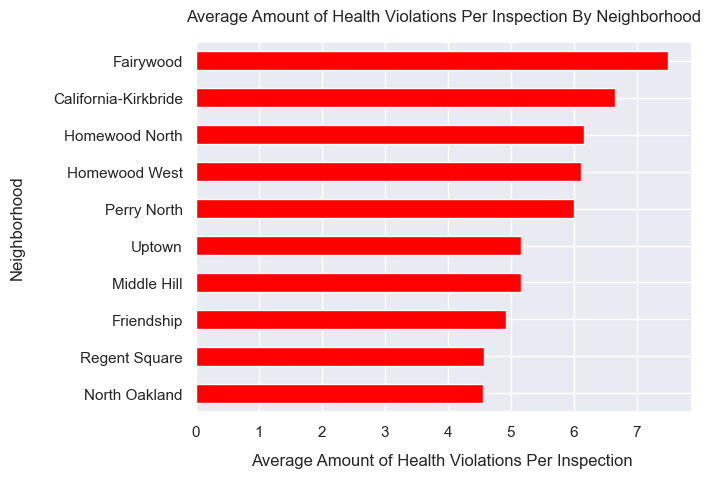

In [85]:
new_list.groupby('neighborhood')['violations_avg'].mean().sort_values().tail(10).plot.barh(legend=False, color="Red")
pyplot.title("Average Amount of Health Violations Per Inspection By Neighborhood", pad=15)
pyplot.xlabel("Average Amount of Health Violations Per Inspection ", labelpad=10)
pyplot.ylabel("Neighborhood", labelpad=20)

(-80.10681505991924, -79.85429464126216, 40.354642646539126, 40.50793371245118)

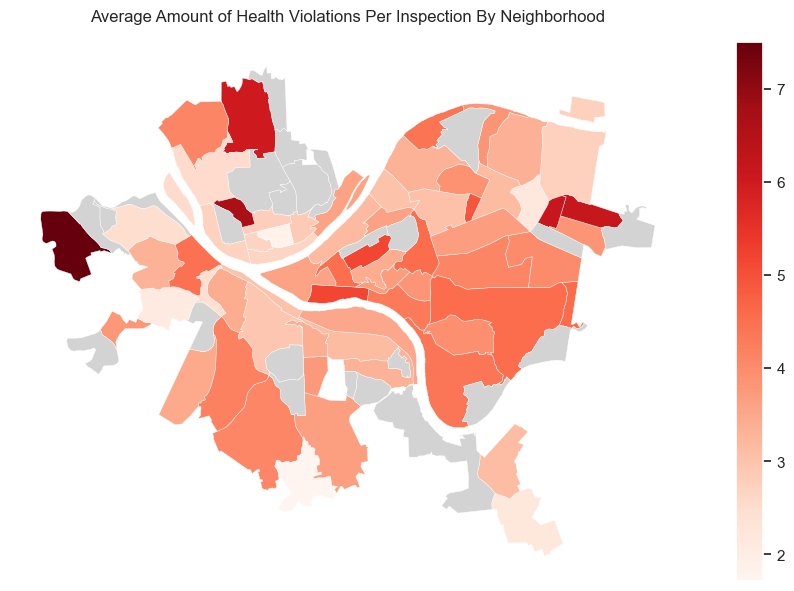

In [86]:
map = generate_map(new_list, "violations_avg")
fig, ax = pyplot.subplots(figsize=(13, 7))
map.plot(ax=ax, column="violations_avg", legend=True, cmap="Reds", linewidth=0.3, missing_kwds={"color": "lightgrey"})
pyplot.title("Average Amount of Health Violations Per Inspection By Neighborhood", pad=15)
pyplot.axis("off")

# Summary

Let's get all our meterics into one place

In [152]:
all_metrics = new_list.groupby('neighborhood')[['rating','violations_avg']].mean().join(business_count).join(fire_incidents_grouped).join(police_incidents_grouped)
all_metrics.head()

,rating,violations_avg,count,fire_incidents,police_incidents
neighborhood,,,,,
Allegheny Center,4.2,1.8,4,40.2,51.0
Allegheny-West,4.5,2.7,10,33.4,31.1
Allentown,4.4,3.4,7,74.0,44.4
Arlington,4.2,3.3,2,19.5,15.5
Bakery Square,4.3,3.0,10,5.1,6.8



Pandas has automatically droped neighboorhoods that weren't included in all datasets, so we have 68 neighboors to 
consider.

Now lets compute the rank of each neighboor for each meteric. Lower the number, the better.

We also have to consider that

High ratings are **good**

High violations,fires, and police incidents are **bad**

We make the ratings negative before we compute the rank so that having a having a high rank (being number #1)
is always a bad thing.


In [153]:
all_metrics['rating']*=-1
all_metrics["count"] *= -1

In [231]:
pandas.set_option('display.float_format', '{:.1f}'.format)
rankings = all_metrics.rank()
rankings

,rating,violations_avg,fire_incidents,police_incidents
neighborhood,,,,
Allegheny Center,56.0,3.0,57.0,65.0
Allegheny-West,17.0,11.0,50.0,51.0
Allentown,26.0,29.0,68.0,64.0
Arlington,45.5,25.0,30.0,28.0
Bakery Square,43.5,17.0,5.0,12.0
...,...,...,...,...
Troy Hill,15.0,35.0,28.0,22.0
Uptown,39.0,63.0,52.0,62.0
West End,22.0,7.0,7.0,2.5


lets sum all the colums and sort them, remember high numbers are good.

Text(0, 0.5, 'Neighborhood')

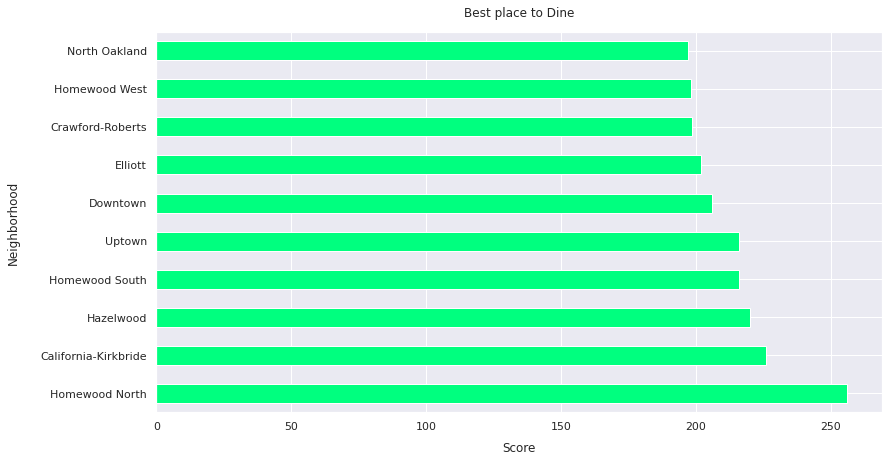

In [233]:
final_scores = rankings.sum(axis='columns').sort_values(ascending=False)

fig, ax = pyplot.subplots(figsize=(13, 7))
final_scores.head(10).plot.barh(legend=False, color="springgreen")
pyplot.title("Best place to Dine", pad=15)
pyplot.xlabel("Score", labelpad=10)
pyplot.ylabel("Neighborhood", labelpad=20)


(-80.10681505991924, -79.85429464126216, 40.354642646539126, 40.50793371245118)

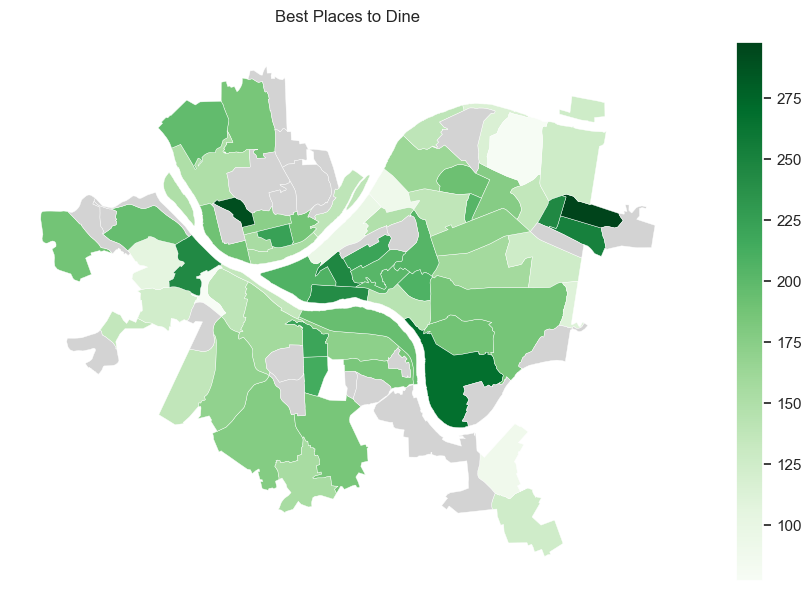

In [156]:
map = generate_map(final_scores.reset_index(level=0).rename(columns={0:'dining_value'}),'dining_value')
fig, ax = pyplot.subplots(figsize=(13, 7))
map.plot(ax=ax, column="dining_value", legend=True, cmap="Greens", linewidth=0.3, missing_kwds={"color": "lightgrey"})
pyplot.title("Best Places to Dine", pad=15)
pyplot.axis("off")

# Conclusion

### tim
I really haven't been around pittsburgh at all, so I can't really judge the outcome. 
